# **Homework 8 - Sequence-to-sequence**

https://colab.research.google.com/drive/11iwJbQv9iScRo6kGP7YfyHaaorlHhzMT

若有任何問題，歡迎來信至助教信箱 ntu-ml-2020spring-ta@googlegroups.com

# Sequence-to-Sequence 介紹
- 大多數常見的 **sequence-to-sequence (seq2seq) model** 為 **encoder-decoder model**，主要由兩個部分組成，分別是 **Encoder** 和 **Decoder**，而這兩個部分則大多使用 **recurrent neural network (RNN)** 來實作，主要是用來解決輸入和輸出的長度不一樣的情況
- **Encoder** 是將**一連串**的輸入，如文字、影片、聲音訊號等，編碼為**單個向量**，這單個向量可以想像為是整個輸入的抽象表示，包含了整個輸入的資訊
- **Decoder** 是將 Encoder 輸出的單個向量逐步解碼，**一次輸出一個結果**，直到將最後目標輸出被產生出來為止，每次輸出會影響下一次的輸出，一般會在開頭加入 "< BOS >" 來表示開始解碼，會在結尾輸出 "< EOS >" 來表示輸出結束


![seq2seq](https://i.imgur.com/0zeDyuI.png)

# 作業介紹
- 英文翻譯中文
  - 輸入： 一句英文 （e.g.		tom is a student .） 
  - 輸出： 中文翻譯 （e.g. 		湯姆 是 個 學生 。）

- TODO
  - Teachering Forcing 的功用: 嘗試不用 Teachering Forcing 做訓練
  - 實作 Attention Mechanism
  - 實作 Beam Search
  - 實作 Schedule Sampling

# 資料下載

In [1]:
# !gdown --id '1r4px0i-NcrnXy1-tkBsIwvYwbWnxAhcg' --output data.tar.gz
# !tar -zxvf data.tar.gz
# !mkdir ckpt
# !ls

# 下載和引入需要的 libraries

In [2]:
!pip install --user nltk

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
import torch.utils.data.sampler as sampler
import torchvision
from torchvision import datasets, transforms
import inspect


import numpy as np
import sys
import os
import random
import json
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 判斷是用 CPU 還是 GPU 執行運算


# 資料結構

## 定義資料的轉換
- 將不同長度的答案拓展到相同長度，以便訓練模型

In [4]:
import numpy as np

from data import LabelTransform
lines = inspect.getsource(LabelTransform)
print(lines)


class LabelTransform(object):
    def __init__(self, size, pad):
        self.size = size
        self.pad = pad

    def __call__(self, label):
        label = np.pad(label, (0, (self.size - label.shape[0])), mode='constant', constant_values=self.pad)
        return label



## 定義 Dataset
- Data (出自manythings 的 cmn-eng):
  - 訓練資料：18000句
  - 檢驗資料：  500句
  - 測試資料： 2636句

- 資料預處理:
  - 英文：
    - 用 subword-nmt 套件將word轉為subword
    - 建立字典：取出標籤中出現頻率高於定值的subword
  - 中文：
    - 用 jieba 將中文句子斷詞
    - 建立字典：取出標籤中出現頻率高於定值的詞
  - 特殊字元： < PAD >, < BOS >, < EOS >, < UNK > 
    - < PAD >  ：無意義，將句子拓展到相同長度
    - < BOS >  ：Begin of sentence, 開始字元
    - < EOS >  ：End of sentence, 結尾字元
    - < UNK > ：單字沒有出現在字典裡的字
  - 將字典裡每個 subword (詞) 用一個整數表示，分為英文和中文的字典，方便之後轉為 one-hot vector   

- 處理後的檔案:
  - 字典：
    - int2word_*.json: 將整數轉為文字
    ![int2word_en.json](https://i.imgur.com/31E4MdZ.png)
    - word2int_*.json: 將文字轉為整數
    ![word2int_en.json](https://i.imgur.com/9vI4AS1.png)
    - $*$ 分為英文（en）和中文（cn）
  
  - 訓練資料:
    - 不同語言的句子用 TAB ('\t') 分開
    - 字跟字之間用空白分開
    ![data](https://i.imgur.com/nSH1fH4.png)


- 在將答案傳出去前，在答案開頭加入 "< BOS >" 符號，並於答案結尾加入 "< EOS >" 符號

In [5]:
from data import EN2CNDataset
lines = inspect.getsource(EN2CNDataset)
print(lines)

class EN2CNDataset(data.Dataset):
    def __init__(self, root, max_output_len, set_name):
        self.root = root

        self.word2int_cn, self.int2word_cn = self.get_dictionary('cn')
        self.word2int_en, self.int2word_en = self.get_dictionary('en')

        # 載入資料
        self.data = []
        with open(os.path.join(self.root, f'{set_name}.txt'), "r") as f:
            for line in f:
                self.data.append(line)
        print (f'{set_name} dataset size: {len(self.data)}')

        self.cn_vocab_size = len(self.word2int_cn)
        self.en_vocab_size = len(self.word2int_en)
        self.transform = LabelTransform(max_output_len, self.word2int_en['<PAD>'])

    def get_dictionary(self, language):
        # 載入字典
        with open(os.path.join(self.root, f'word2int_{language}.json'), "r") as f:
            word2int = json.load(f)
        with open(os.path.join(self.root, f'int2word_{language}.json'), "r") as f:
            int2word = json.load(f)
        return word2int

# 模型架構

## Encoder
- seq2seq模型的編碼器為RNN。 對於每個輸入，，**Encoder** 會輸出**一個向量**和**一個隱藏狀態(hidden state)**，並將隱藏狀態用於下一個輸入，換句話說，**Encoder** 會逐步讀取輸入序列，並輸出單個矢量（最終隱藏狀態）
- 參數:
  - en_vocab_size 是英文字典的大小，也就是英文的 subword 的個數
  - emb_dim 是 embedding 的維度，主要將 one-hot vector 的單詞向量壓縮到指定的維度，主要是為了降維和濃縮資訊的功用，可以使用預先訓練好的 word embedding，如 Glove 和 word2vector
  - hid_dim 是 RNN 輸出和隱藏狀態的維度
  - n_layers 是 RNN 要疊多少層
  - dropout 是決定有多少的機率會將某個節點變為 0，主要是為了防止 overfitting ，一般來說是在訓練時使用，測試時則不使用
- Encoder 的輸入和輸出:
  - 輸入: 
    - 英文的整數序列 e.g. 1, 28, 29, 205, 2
  - 輸出: 
    - outputs: 最上層 RNN 全部的輸出，可以用 Attention 再進行處理
    - hidden: 每層最後的隱藏狀態，將傳遞到 Decoder 進行解碼


In [6]:
from model import Encoder
lines = inspect.getsource(Encoder)
print(lines)

class Encoder(nn.Module):
    def __init__(self, en_vocab_size, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(en_vocab_size, emb_dim)
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.rnn = nn.GRU(emb_dim, hid_dim, n_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input):
        # input = [batch size, sequence len, vocab size]
        embedding = self.embedding(input)
        outputs, hidden = self.rnn(self.dropout(embedding))
        # outputs = [batch size, sequence len, hid dim * directions]
        # hidden =  [num_layers * directions, batch size  , hid dim]
        # outputs 是最上層RNN的輸出
        
        return outputs, hidden



## Decoder
- **Decoder** 是另一個 RNN，在最簡單的 seq2seq decoder 中，僅使用 **Encoder** 每一層最後的隱藏狀態來進行解碼，而這最後的隱藏狀態有時被稱為 “content vector”，因為可以想像它對整個前文序列進行編碼， 此 “content vector” 用作 **Decoder** 的**初始**隱藏狀態， 而 **Encoder** 的輸出通常用於 Attention Mechanism
- 參數
  - en_vocab_size 是英文字典的大小，也就是英文的 subword 的個數
  - emb_dim 是 embedding 的維度，是用來將 one-hot vector 的單詞向量壓縮到指定的維度，主要是為了降維和濃縮資訊的功用，可以使用預先訓練好的 word embedding，如 Glove 和 word2vector
  - hid_dim 是 RNN 輸出和隱藏狀態的維度
  - output_dim 是最終輸出的維度，一般來說是將 hid_dim 轉到 one-hot vector 的單詞向量
  - n_layers 是 RNN 要疊多少層
  - dropout 是決定有多少的機率會將某個節點變為0，主要是為了防止 overfitting ，一般來說是在訓練時使用，測試時則不用
  - isatt 是來決定是否使用 Attention Mechanism

- Decoder 的輸入和輸出:
  - 輸入:
    - 前一次解碼出來的單詞的整數表示
  - 輸出:
    - hidden: 根據輸入和前一次的隱藏狀態，現在的隱藏狀態更新的結果
    - output: 每個字有多少機率是這次解碼的結果

In [7]:
from model import Decoder
lines = inspect.getsource(Decoder)
print(lines)

class Decoder(nn.Module):
    def __init__(self, cn_vocab_size, emb_dim, hid_dim, n_layers, dropout, isatt):
        super().__init__()
        self.cn_vocab_size = cn_vocab_size
        self.hid_dim = hid_dim * 2
        self.n_layers = n_layers
        self.embedding = nn.Embedding(cn_vocab_size, emb_dim)
        self.isatt = isatt
        self.attention = Attention(hid_dim)
        # 如果使用 Attention Mechanism 會使得輸入維度變化，請在這裡修改
        # e.g. Attention 接在輸入後面會使得維度變化，所以輸入維度改為
        self.input_dim = emb_dim + hid_dim * 2 if isatt else emb_dim
        # self.input_dim = emb_dim
        self.rnn = nn.GRU(self.input_dim, self.hid_dim, self.n_layers, dropout = dropout, batch_first=True)
        self.embedding2vocab1 = nn.Linear(self.hid_dim, self.hid_dim * 2)
        self.embedding2vocab2 = nn.Linear(self.hid_dim * 2, self.hid_dim * 4)
        self.embedding2vocab3 = nn.Linear(self.hid_dim * 4, self.cn_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hid

## Attention
- 當輸入過長，或是單獨靠 “content vector” 無法取得整個輸入的意思時，用 Attention Mechanism 來提供 **Decoder** 更多的資訊
- 主要是根據現在 **Decoder hidden state** ，去計算在 **Encoder outputs** 中，那些與其有較高的關係，根據關系的數值來決定該傳給 **Decoder** 那些額外資訊 
- 常見 Attention 的實作是用 Neural Network / Dot Product 來算 **Decoder hidden state** 和 **Encoder outputs** 之間的關係，再對所有算出來的數值做 **softmax** ，最後根據過完 **softmax** 的值對 **Encoder outputs** 做 **weight sum**

https://zhuanlan.zhihu.com/p/53682800

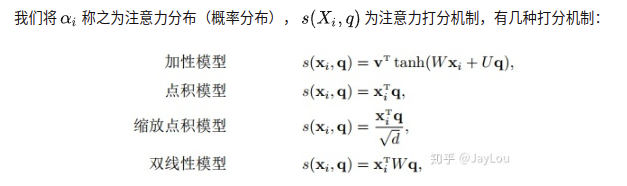

- TODO:
實作 Attention Mechanism
https://github.com/bentrevett/pytorch-seq2seq/blob/master/3%20-%20Neural%20Machine%20Translation%20by%20Jointly%20Learning%20to%20Align%20and%20Translate.ipynb

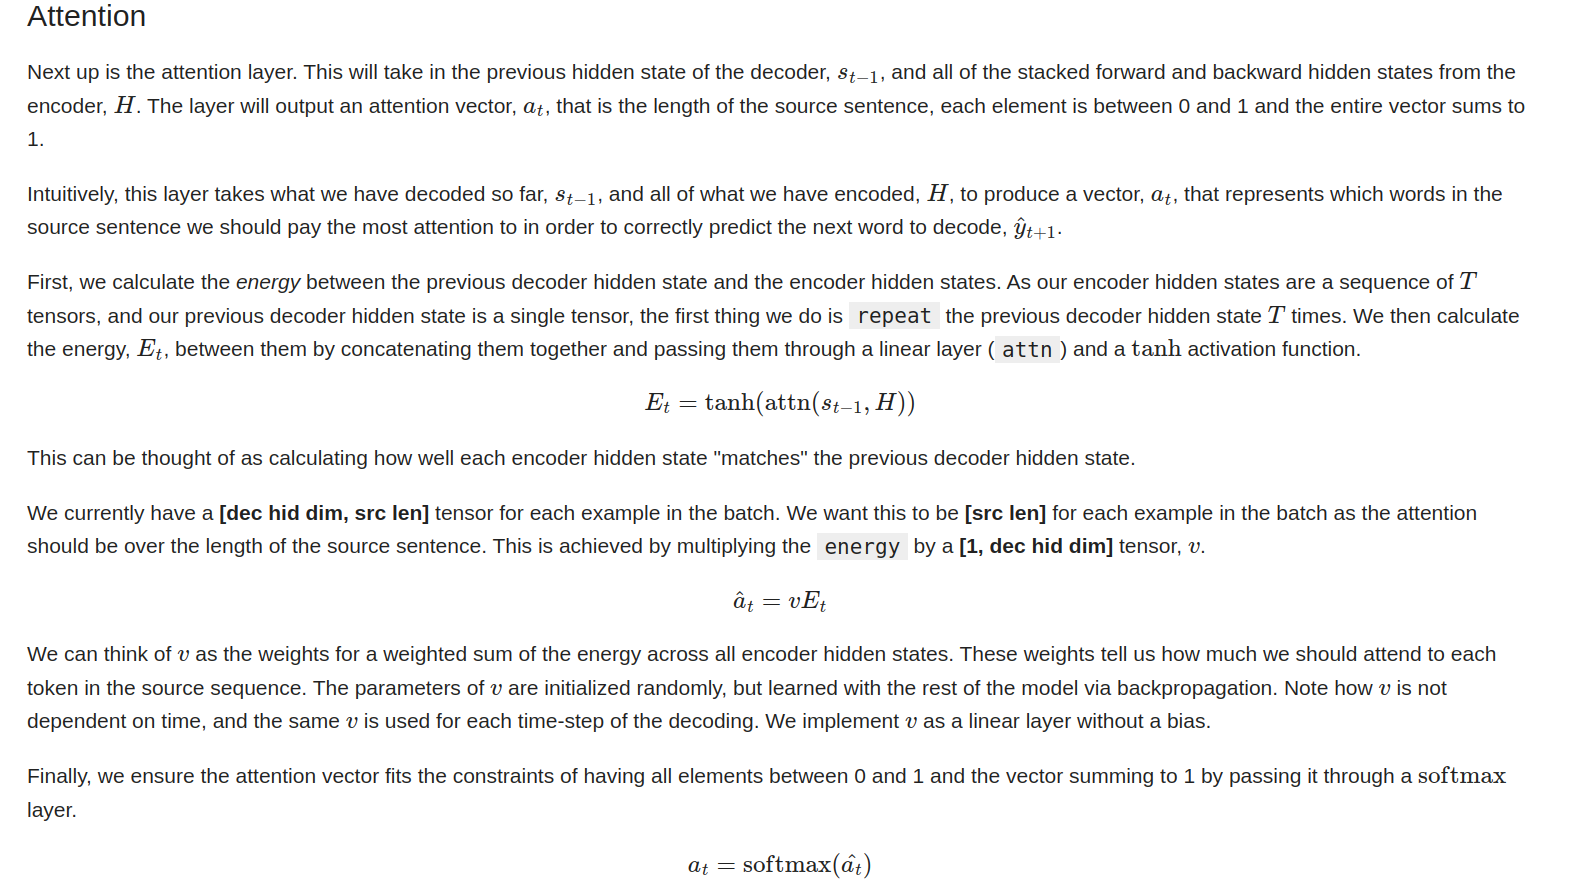

In [8]:
from model import Attention
lines = inspect.getsource(Attention)
print(lines)

class Attention(nn.Module):
    def __init__(self, hid_dim):
        super(Attention, self).__init__()
        self.hid_dim = hid_dim
        
        self.enc_dim = self.dec_hid_dim = hid_dim * 2
        self.attn = nn.Linear(self.enc_dim + self.dec_hid_dim, self.dec_hid_dim)
        self.v = nn.Linear(self.dec_hid_dim, 1, bias = False)
        
        self.cos = nn.CosineSimilarity(dim=2, eps=1e-6)
  
    def forward(self, encoder_outputs, decoder_hidden):
        # encoder_outputs = [batch size, sequence len, hid dim * directions]
        # decoder_hidden = [num_layers, batch size, hid dim]
        # 一般來說是取 Encoder 最後一層的 hidden state 來做 attention
        ########
        # TODO #
        ########
        attention=None  

        # Linear
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        
        #hidden = [batch size, dec hid dim]
        decoder_hidden = decoder_hidden.permute(1, 0, 2)[:, -1:, :]        
        
        #repeat deco

## Seq2Seq
- 由 **Encoder** 和 **Decoder** 組成
- 接收輸入並傳給 **Encoder** 
- 將 **Encoder** 的輸出傳給 **Decoder**
- 不斷地將 **Decoder** 的輸出傳回 **Decoder** ，進行解碼  
- 當解碼完成後，將 **Decoder** 的輸出傳回 

In [9]:
from model import Seq2Seq
lines = inspect.getsource(Seq2Seq)
print(lines)

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        assert encoder.n_layers == decoder.n_layers, \
                "Encoder and decoder must have equal number of layers!"
        
            
    def forward(self, input, target, teacher_forcing_ratio):
        # input  = [batch size, input len, vocab size]
        # target = [batch size, target len, vocab size]
        # teacher_forcing_ratio 是有多少機率使用正確答案來訓練
        batch_size = target.shape[0]
        target_len = target.shape[1]
        vocab_size = self.decoder.cn_vocab_size

        # 準備一個儲存空間來儲存輸出
        outputs = torch.zeros(batch_size, target_len, vocab_size).to(self.device)
        # 將輸入放入 Encoder
        encoder_outputs, hidden = self.encoder(input)
        # Encoder 最後的隱藏層(hidden state) 用來初始化 Decoder
        # encoder_outputs 主要是使用在 Attention
        # 因為 Encoder 是雙向的RNN，所以需要將

# utils
- 基本操作:
  - 儲存模型
  - 載入模型
  - 建構模型
  - 將一連串的數字還原回句子
  - 計算 BLEU score
  - 迭代 dataloader
  

## 儲存模型

In [10]:
from utils import save_model
lines = inspect.getsource(save_model)
print(lines)

def save_model(model, optimizer, store_model_path, step):
    torch.save(model.state_dict(), f'{store_model_path}/model_{step}.ckpt')
    return



## 載入模型

In [11]:
from utils import load_model
lines = inspect.getsource(load_model)
print(lines)

def load_model(model, load_model_path):
    print(f'Load model from {load_model_path}')
    model.load_state_dict(torch.load(f'{load_model_path}.ckpt'))
    return model    



## 建構模型

In [12]:
from utils import build_model
lines = inspect.getsource(build_model)
print(lines)

def build_model(config, en_vocab_size, cn_vocab_size):
    # 建構模型
    encoder = Encoder(en_vocab_size, config.emb_dim, config.hid_dim, config.n_layers, config.dropout)
    decoder = Decoder(cn_vocab_size, config.emb_dim, config.hid_dim, config.n_layers, config.dropout, config.attention)
    model = Seq2Seq(encoder, decoder, device)
    print(model)
    # 建構 optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    print(optimizer)
    if config.load_model:
        model = load_model(model, config.load_model_path)
    model = model.to(device)

    return model, optimizer



## 數字轉句子

In [13]:
from utils import tokens2sentence
lines = inspect.getsource(tokens2sentence)
print(lines)

def tokens2sentence(outputs, int2word):
    sentences = []
    for tokens in outputs:
        sentence = []
        for token in tokens:
            word = int2word[str(int(token))]
            if word == '<EOS>':
                break
            sentence.append(word)
        sentences.append(sentence)
  
    return sentences



## 計算 BLEU score

In [14]:
from eval import computebleu
lines = inspect.getsource(computebleu)
print(lines)

def computebleu(sentences, targets):
    score = 0 
    assert (len(sentences) == len(targets))

    def cut_token(sentence):
        tmp = []
        for token in sentence:
            if token == '<UNK>' or token.isdigit() or len(bytes(token[0], encoding='utf-8')) == 1:
                tmp.append(token)
            else:
                tmp += [word for word in token]
        return tmp 

    for sentence, target in zip(sentences, targets):
        sentence = cut_token(sentence)
        target = cut_token(target)
        score += sentence_bleu([target], sentence, weights=(1, 0, 0, 0))                                                                                          
  
    return score



## 迭代 dataloader

In [15]:
from data import infinite_iter
lines = inspect.getsource(infinite_iter)
print(lines)

def infinite_iter(data_loader):
    it = iter(data_loader)
    while True:
        try:
            ret = next(it)
            yield ret
        except StopIteration:
            it = iter(data_loader)



## schedule_sampling
https://www.jiqizhixin.com/wp-content/uploads/2015/11/4.-Scheduled-Sampling-for-Sequence-Prediction-with-Recurrent-Neural-Networks-.pdf
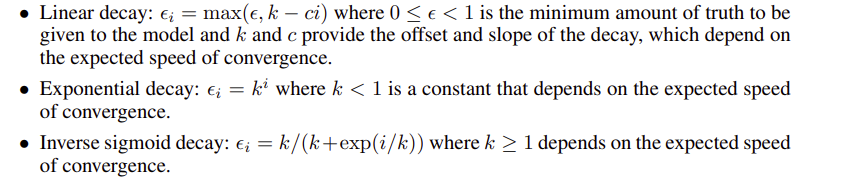

In [16]:
from process import schedule_sampling
lines = inspect.getsource(schedule_sampling)
print(lines)    

def schedule_sampling(ss_start, steps, summary_steps):
    epoch_i = int(steps / summary_steps)
    
    
    # Linear decay
    decay = 0.005
    ld_samp = ss_start - decay * epoch_i
    # print("Linear decay: ", ld_samp , end = "\r")
    
    # Exponential decay
    k = 0.8
    ed_samp = k ** epoch_i
    # print("Exponential decay: ", ed_samp , end = "\r")
    
    # Inverse sigmoid decay
    k = 1.1
    isd_samp = k/(k + math.exp( epoch_i / k ))
    
    # print("Inverse sigmoid decay: ", isd_samp , end = "\r")
    return ed_samp



# 訓練步驟

## 訓練
- 訓練階段

In [17]:

from process import train
lines = inspect.getsource(train)
print(lines)

def train(model, optimizer, train_iter, loss_function, total_steps, summary_steps, train_dataset, samples):
    model.train()
    model.zero_grad()
    losses = []
    loss_sum = 0.0
    ss_start = 1.0
    for step in range(summary_steps):             
        sources, targets = next(train_iter)
        sources, targets = sources.to(device), targets.to(device)
        
        sample=schedule_sampling(ss_start, total_steps + step, summary_steps)
        samples.append(sample)
        outputs, preds = model(sources, targets, sample)
        # targets 的第一個 token 是 <BOS> 所以忽略
        outputs = outputs[:, 1:].reshape(-1, outputs.size(2))
        targets = targets[:, 1:].reshape(-1)
        loss = loss_function(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        loss_sum += loss.item()
        if (step + 1) % 5 == 0:
            loss_sum = loss_sum / 5
           

## 檢驗/測試
- 防止訓練發生overfitting

In [18]:
from process import test
lines = inspect.getsource(test)
print(lines)

def test(model, dataloader, loss_function):
    model.eval()
    loss_sum, bleu_score= 0.0, 0.0
    n = 0
    result = []
    
    bos, eos = dataloader.dataset.word2int_cn['<BOS>'], dataloader.dataset.word2int_cn['<EOS>']
    vocab = dataloader.dataset.int2word_cn
    
    for sources, targets in dataloader:
        sources, targets = sources.to(device), targets.to(device)
        batch_size = sources.size(0)   
        
        
        # outputs, preds = model.greedy(sources, targets)
        outputs, preds = model.inference(sources, targets, bos, eos, vocab)
        # targets 的第一個 token 是 <BOS> 所以忽略
        outputs = outputs[:, 1:].reshape(-1, outputs.size(2))
        targets = targets[:, 1:].reshape(-1)

        loss = loss_function(outputs, targets)
        loss_sum += loss.item()

        # 將預測結果轉為文字
        targets = targets.view(sources.size(0), -1)
        preds = tokens2sentence(preds, dataloader.dataset.int2word_cn)
        sources = tokens2sentence(sources, dataloader.data

## 訓練流程
- 先訓練，再檢驗

In [19]:
from process import train_process
lines = inspect.getsource(train_process)
print(lines)

def train_process(config):
    # 準備訓練資料
    train_dataset = EN2CNDataset(config.data_path, config.max_output_len, 'training')
    train_loader = data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    train_iter = infinite_iter(train_loader)
    # 準備檢驗資料
    val_dataset = EN2CNDataset(config.data_path, config.max_output_len, 'validation')
    val_loader = data.DataLoader(val_dataset, batch_size=1)           
    
    # 建構模型
    model, optimizer = build_model(config, train_dataset.en_vocab_size, train_dataset.cn_vocab_size)
    loss_function = nn.CrossEntropyLoss(ignore_index=0)

    samples = []
    train_losses, val_losses, bleu_scores = [], [], []
    total_steps = 0
    while (total_steps < config.num_steps):
        # 訓練模型
        model, optimizer, loss = train(model, optimizer, train_iter, loss_function, total_steps, config.summary_steps, train_dataset, samples)
        train_losses += loss
        # 檢驗模型
        val_loss, bleu_score, result = test(model, va

## 測試流程

In [20]:
from process import test_process
lines = inspect.getsource(test_process)
print(lines)

def test_process(config):
    # 準備測試資料
    test_dataset = EN2CNDataset(config.data_path, config.max_output_len, 'testing')
    test_loader = data.DataLoader(test_dataset, batch_size=1)
    # 建構模型
    model, optimizer = build_model(config, test_dataset.en_vocab_size, test_dataset.cn_vocab_size)
    print ("Finish build model")
    loss_function = nn.CrossEntropyLoss(ignore_index=0)
    model.eval()
    # 測試模型
    test_loss, bleu_score, result = test(model, test_loader, loss_function)
    # 儲存結果
    with open(f'./test_output.txt', 'w') as f:
        for line in result:
            print (line, file=f)

    return test_loss, bleu_score



# Config
- 實驗的參數設定表

In [21]:
class configurations(object):
    def __init__(self):
        self.batch_size = 60
        self.emb_dim = 256
        self.hid_dim = 512
        self.n_layers = 3
        self.dropout = 0.5
        self.learning_rate = 5e-4
        self.max_output_len = 50              # 最後輸出句子的最大長度
        self.num_steps = 12000                # 總訓練次數
        self.store_steps = 300                # 訓練多少次後須儲存模型
        self.summary_steps = 300              # 訓練多少次後須檢驗是否有overfitting
        self.load_model = False               # 是否需載入模型
        self.store_model_path = "./ckpt"      # 儲存模型的位置
        self.load_model_path = None           # 載入模型的位置 e.g. "./ckpt/model_{step}" 
        self.data_path = "./cmn-eng"          # 資料存放的位置
        self.attention = True                # 是否使用 Attention Mechanism


# Main Function
- 讀入參數
- 進行訓練或是推論

## train

In [22]:
# if __name__ == '__main__':
config = configurations()
print ('config:\n', vars(config))
train_losses, val_losses, bleu_scores, samples = train_process(config)


config:
 {'batch_size': 60, 'emb_dim': 256, 'hid_dim': 512, 'n_layers': 3, 'dropout': 0.5, 'learning_rate': 0.0005, 'max_output_len': 50, 'num_steps': 12000, 'store_steps': 300, 'summary_steps': 300, 'load_model': False, 'store_model_path': './ckpt', 'load_model_path': None, 'data_path': './cmn-eng', 'attention': True}
training dataset size: 18000
validation dataset size: 500
Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(3922, 256)
    (rnn): GRU(256, 512, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(3805, 256)
    (attention): Attention(
      (attn): Linear(in_features=2048, out_features=1024, bias=True)
      (v): Linear(in_features=1024, out_features=1, bias=False)
      (cos): CosineSimilarity()
    )
    (rnn): GRU(1280, 1024, num_layers=3, batch_first=True, dropout=0.5)
    (embedding2vocab1): Linear(in_features=1024, out_features=2048, bias=True)
   

/home/leyan/.local/lib/python3.6/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/leyan/.local/lib/python3.6/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/leyan/.local/lib/python3.6/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunctio

 val [300] loss: 8.244, Perplexity: 3804.999, blue score: 0.289       
 val [600] loss: 8.244, Perplexity: 3804.999, blue score: 0.324       
 val [900] loss: 8.244, Perplexity: 3804.999, blue score: 0.325       
 val [1200] loss: 8.244, Perplexity: 3804.999, blue score: 0.319       
 val [1500] loss: 8.244, Perplexity: 3804.999, blue score: 0.340       
 val [1800] loss: 8.244, Perplexity: 3804.999, blue score: 0.340       
 val [2100] loss: 8.244, Perplexity: 3804.999, blue score: 0.341       
 val [2400] loss: 8.244, Perplexity: 3804.999, blue score: 0.320       
 val [2700] loss: 8.244, Perplexity: 3804.999, blue score: 0.355       
 val [3000] loss: 8.244, Perplexity: 3804.999, blue score: 0.334       
 val [3300] loss: 8.244, Perplexity: 3804.999, blue score: 0.335       
 val [3600] loss: 8.244, Perplexity: 3804.999, blue score: 0.345       
 val [3900] loss: 8.244, Perplexity: 3804.999, blue score: 0.341       
 val [4200] loss: 8.244, Perplexity: 3804.999, blue score: 0.326   

## test

In [23]:
class configurations(object):
    def __init__(self):
        self.batch_size = 60
        self.emb_dim = 256
        self.hid_dim = 512
        self.n_layers = 3
        self.dropout = 0.5
        self.learning_rate = 5e-4
        self.max_output_len = 50              # 最後輸出句子的最大長度
        self.num_steps = 12000                # 總訓練次數
        self.store_steps = 300                # 訓練多少次後須儲存模型
        self.summary_steps = 300              # 訓練多少次後須檢驗是否有overfitting
        self.load_model = True               # 是否需載入模型
        self.store_model_path = "./ckpt"      # 儲存模型的位置
        self.load_model_path = "./ckpt/model_12000"           # 載入模型的位置 e.g. "./ckpt/model_{step}" 
        self.data_path = "./cmn-eng"          # 資料存放的位置
        self.attention = True                # 是否使用 Attention Mechanism

In [24]:
# 在執行 Test 之前，請先行至 config 設定所要載入的模型位置
# if __name__ == '__main__':
config = configurations()
print ('config:\n', vars(config))
test_loss, bleu_score = test_process(config)
print (f'test loss: {test_loss}, bleu_score: {bleu_score}')
        

config:
 {'batch_size': 60, 'emb_dim': 256, 'hid_dim': 512, 'n_layers': 3, 'dropout': 0.5, 'learning_rate': 0.0005, 'max_output_len': 50, 'num_steps': 12000, 'store_steps': 300, 'summary_steps': 300, 'load_model': True, 'store_model_path': './ckpt', 'load_model_path': './ckpt/model_12000', 'data_path': './cmn-eng', 'attention': True}
testing dataset size: 2636
Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(3922, 256)
    (rnn): GRU(256, 512, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(3805, 256)
    (attention): Attention(
      (attn): Linear(in_features=2048, out_features=1024, bias=True)
      (v): Linear(in_features=1024, out_features=1, bias=False)
      (cos): CosineSimilarity()
    )
    (rnn): GRU(1280, 1024, num_layers=3, batch_first=True, dropout=0.5)
    (embedding2vocab1): Linear(in_features=1024, out_features=2048, bias=True)
    (embedding2voca

# 圖形化訓練過程

## 以圖表呈現 訓練 的 loss 變化趨勢


/home/leyan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 27425 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/leyan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 25976 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/leyan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 27425 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/leyan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 25976 missing from current font.
  font.set_text(s, 0, flags=flags)


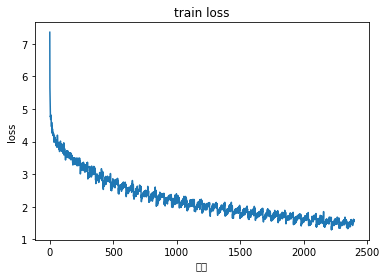

In [25]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_losses)
plt.xlabel('次數')
plt.ylabel('loss')
plt.title('train loss')
plt.show()

## 以圖表呈現 檢驗 的 loss 變化趨勢

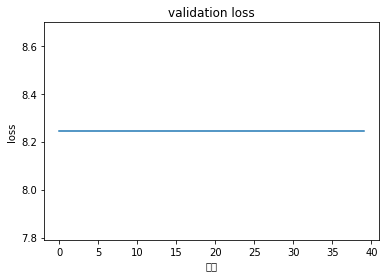

In [26]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(val_losses)
plt.xlabel('次數')
plt.ylabel('loss')
plt.title('validation loss')
plt.show()

## 以圖表呈現 檢驗 的 scheduler 變化趨勢

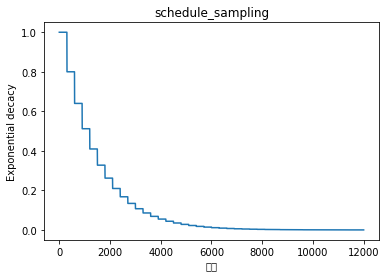

In [27]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(samples)
plt.xlabel('次數')
plt.ylabel('Exponential decacy')
plt.title('schedule_sampling')
plt.show()

## BLEU score

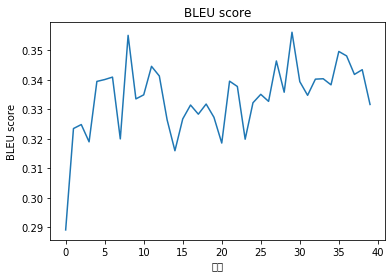

In [28]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(bleu_scores)
plt.xlabel('次數')
plt.ylabel('BLEU score')
plt.title('BLEU score')
plt.show()